In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
import time


In [6]:
data = pd.read_csv('Data.csv')

In [7]:
data.head()

,Hours_Studied,Previous_Scores,Extracurricular_Activities,Sleep_Hours,Sample_Question_Papers_Practiced,Performance_Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [8]:
print(data.columns)

Index(['Hours_Studied', 'Previous_Scores', 'Extracurricular_Activities',
       'Sleep_Hours', 'Sample_Question_Papers_Practiced', 'Performance_Index'],
      dtype='object')


In [9]:
data['Extracurricular_Activities'] = data['Extracurricular_Activities'].apply(lambda x: 1 if x == 'Yes' else 0)

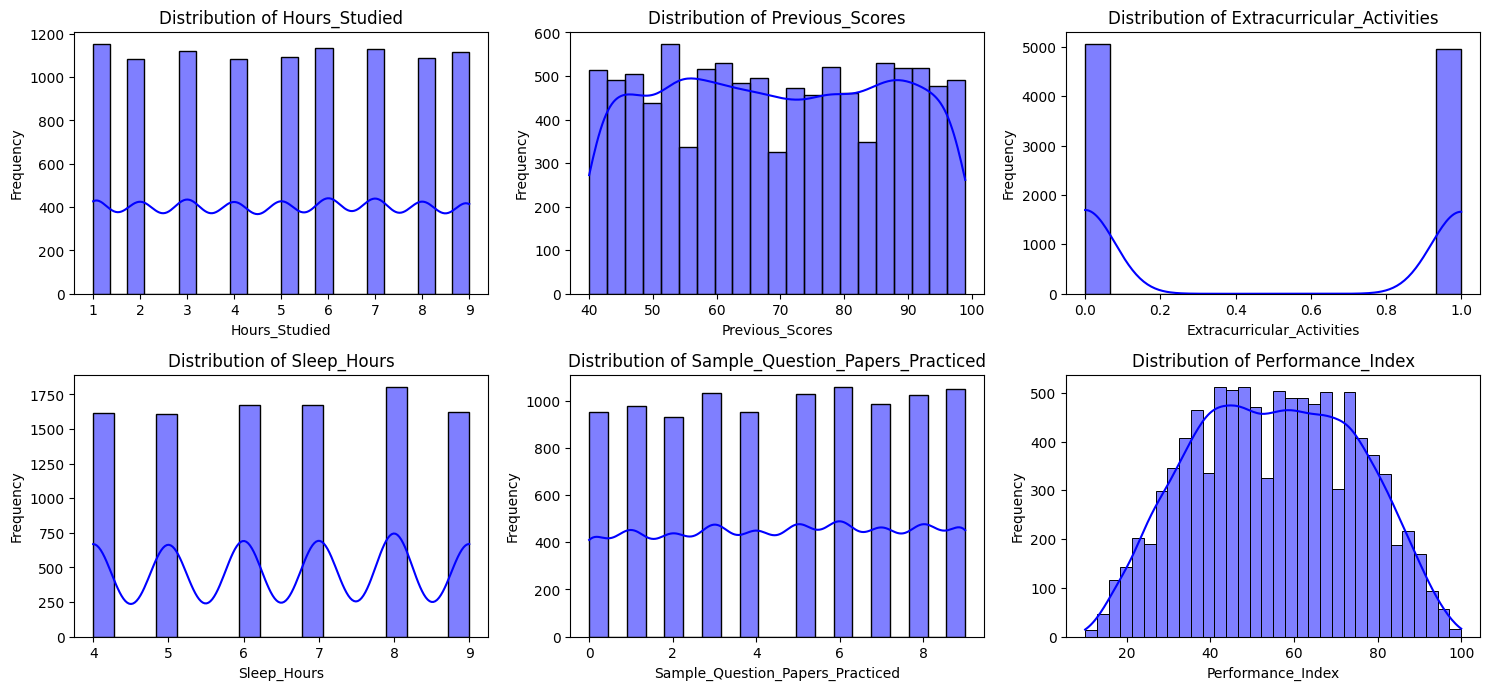

In [10]:
plt.figure(figsize=(15, 10))  
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)  
    sns.histplot(data[column], kde=True, color='blue')  
    plt.title(f'Distribution of {column}')  
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()

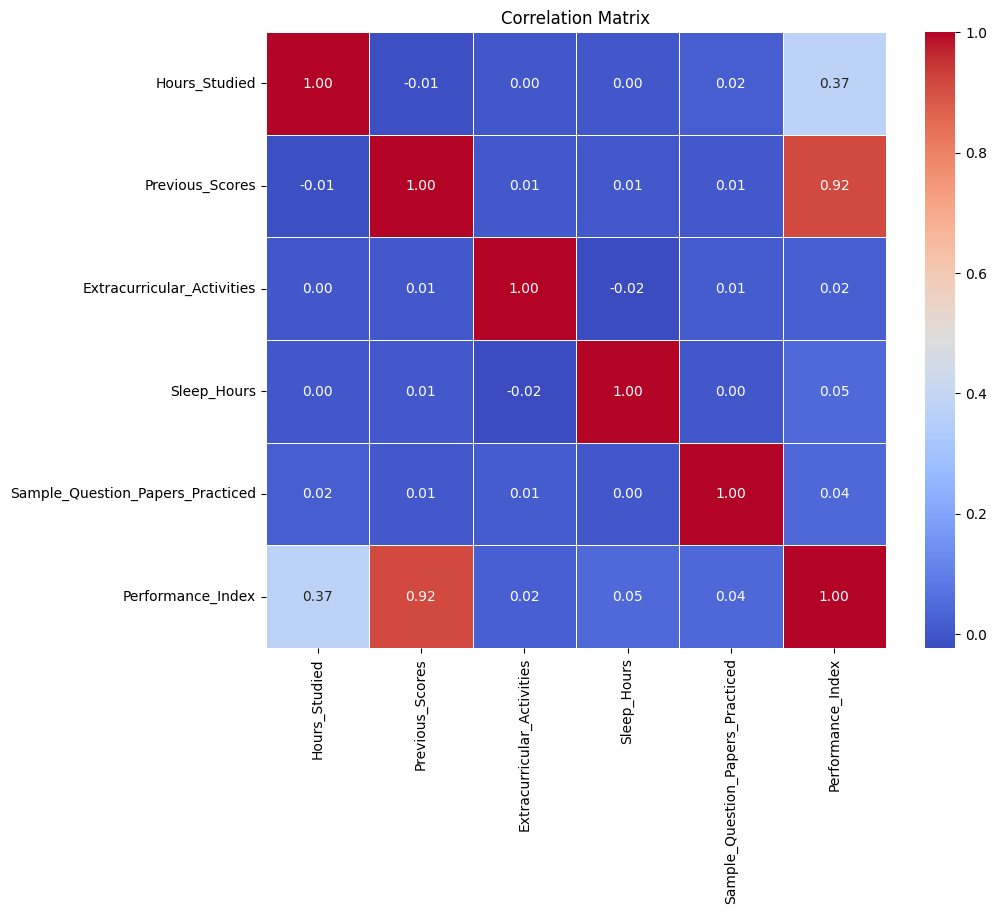

In [11]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix')

plt.show()

In [12]:
print("Checking missing values:")
print(data.isnull().sum())

Checking missing values:
Hours_Studied                       0
Previous_Scores                     0
Extracurricular_Activities          0
Sleep_Hours                         0
Sample_Question_Papers_Practiced    0
Performance_Index                   0
dtype: int64


In [13]:
data['Hours_Studied'] = data['Hours_Studied'].fillna(data['Hours_Studied'].mean())
data['Sleep_Hours'] = data['Sleep_Hours'].fillna(data['Sleep_Hours'].mean())

In [14]:

data['Extracurricular_Activities'] = data['Extracurricular_Activities'].fillna(data['Extracurricular_Activities'].mode()[0])

In [15]:
X = data.drop(columns=['Performance_Index'])
y = data['Performance_Index']

In [16]:
print("Before removing outliers:")
print(data.describe())

Before removing outliers:
       Hours_Studied  ...  Performance_Index
count   10000.000000  ...       10000.000000
mean        4.992900  ...          55.224800
std         2.589309  ...          19.212558
min         1.000000  ...          10.000000
25%         3.000000  ...          40.000000
50%         5.000000  ...          55.000000
75%         7.000000  ...          71.000000
max         9.000000  ...         100.000000

[8 rows x 6 columns]


In [17]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [18]:
data = remove_outliers(data, 'Hours_Studied')
data = remove_outliers(data, 'Previous_Scores')
data = remove_outliers(data, 'Sleep_Hours')

In [19]:
print("After removing outliers:")
print(data.describe())

After removing outliers:
       Hours_Studied  ...  Performance_Index
count   10000.000000  ...       10000.000000
mean        4.992900  ...          55.224800
std         2.589309  ...          19.212558
min         1.000000  ...          10.000000
25%         3.000000  ...          40.000000
50%         5.000000  ...          55.000000
75%         7.000000  ...          71.000000
max         9.000000  ...         100.000000

[8 rows x 6 columns]


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

LINEAR REGRESSION

In [23]:
start_time = time.time()
model_Linear = LinearRegression()
model_Linear.fit(X_train_scaled, y_train)
joblib.dump(model_Linear, 'model_linear.pkl')

['model_linear.pkl']

In [24]:
y_pred = model_Linear.predict(X_test_scaled)
time_linear = time.time() - start_time

In [25]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [26]:
data_Linear = {
    'Hàm đánh giá': ['MAE', 'MSE', 'R²'],
    'Giá trị': [mae, mse, r2]
}
model_evaluation_table_Linear = pd.DataFrame(data_Linear)
print("\n\nModel Evaluation Table:")
print(model_evaluation_table_Linear.to_string(index=False))
print("\n\n")



Model Evaluation Table:
Hàm đánh giá  Giá trị
         MAE 1.611121
         MSE 4.082628
          R² 0.988983





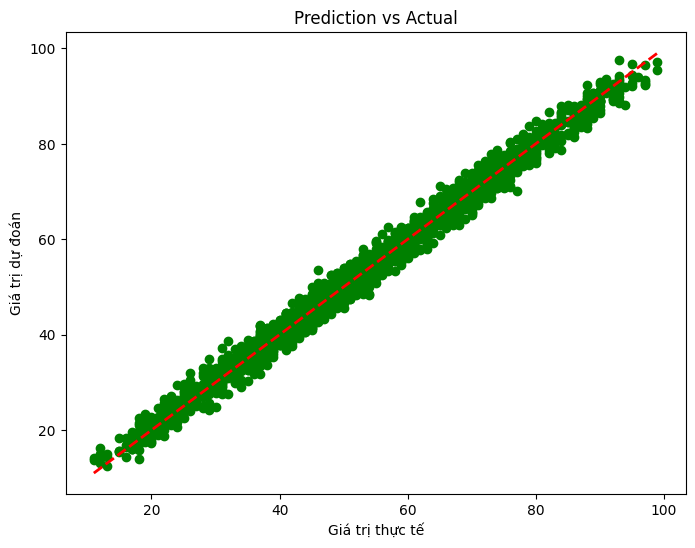

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Prediction vs Actual")
plt.show()

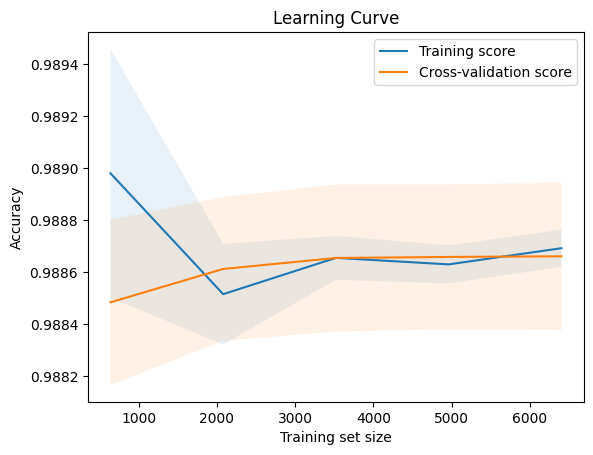

In [28]:
train_sizes, train_scores, test_scores = learning_curve(model_Linear, X_train_scaled, y_train, cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

LASSO REGRESSION

In [29]:
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_values = [5]
results = []

lasso = Lasso()

param_grid = {'alpha': alpha_values}
start_time = time.time()
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=cv_values[0], scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train)
best_alpha = grid.best_params_['alpha']
model_lasso = grid.best_estimator_
joblib.dump(model_lasso, 'model_lasso.pkl')


['model_lasso.pkl']

In [30]:
y_pred_lasso = model_lasso.predict(X_test_scaled)
time_lasso = time.time() - start_time
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

results.append({
    'Alpha': best_alpha,
    'CV': cv_values[0],
    'MAE': mae_lasso,
    'MSE': mse_lasso,
    'R²': r2_lasso
})


In [31]:
results_df = pd.DataFrame(results)
print("\n\nComparison of Models with Different Alpha and CV:")
print(results_df)

best_model_index = results_df['R²'].idxmax()
best_model_params = results_df.loc[best_model_index]
print("\nBest Model Parameters:")
print(best_model_params)



Comparison of Models with Different Alpha and CV:
   Alpha  CV       MAE       MSE        R²
0  0.001   5  1.611168  4.083043  0.988982

Best Model Parameters:
Alpha    0.001000
CV       5.000000
MAE      1.611168
MSE      4.083043
R²       0.988982
Name: 0, dtype: float64


In [32]:
print("\n\nBest Model Parameters:")
print(best_model_params)



Best Model Parameters:
Alpha    0.001000
CV       5.000000
MAE      1.611168
MSE      4.083043
R²       0.988982
Name: 0, dtype: float64


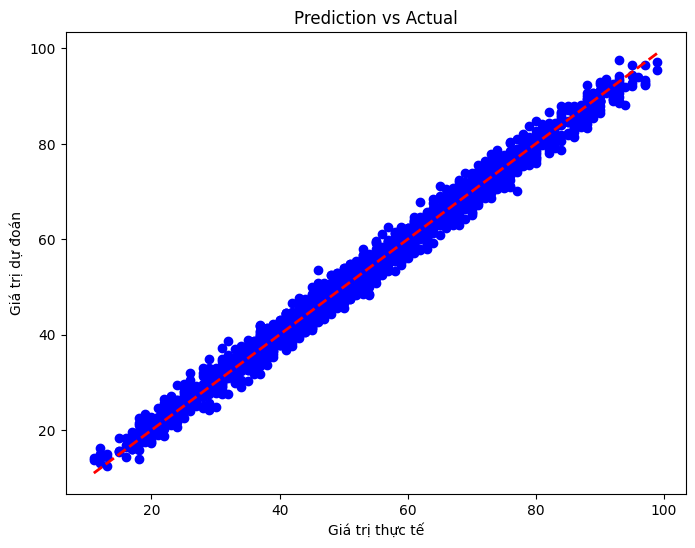

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lasso, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Prediction vs Actual")
plt.show()


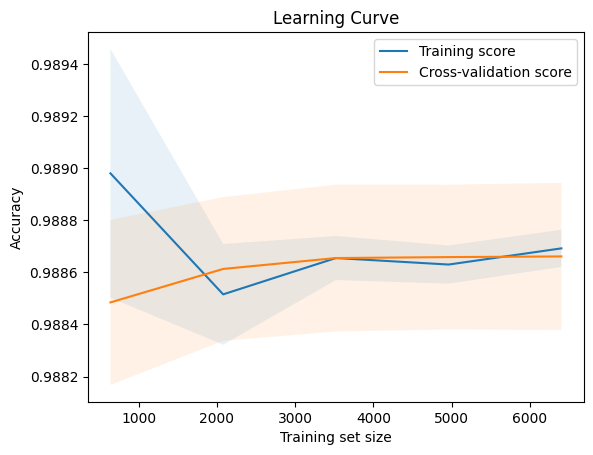

In [34]:
train_sizes, train_scores, test_scores = learning_curve(model_lasso, X_train_scaled, y_train, cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

NEURAL NETWORK (MPL REGRESSION)

In [35]:
mlp = MLPRegressor()

In [36]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # số lượng neuron và tầng ẩn
    'activation': ['relu', 'tanh'],   # hàm kích hoạt
    'solver': ['adam', 'sgd'],        # thuật toán tối ưu
    'learning_rate': ['constant', 'adaptive'],  # tốc độ học
    'max_iter': [500, 1000, 2000],  # số lần lặp (epoch)
    'alpha': [0.0001, 0.001, 0.01]  # tham số điều chuẩn (regularization)
}
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50), (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [500, 1000, 2000],
                         'solver': ['adam', 'sgd']},
             scoring='neg_mean_squared_error', verbose=2)

In [37]:
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}


In [38]:
start_time = time.time()
model_MLP = grid_search.best_estimator_

In [39]:
joblib.dump(model_MLP, 'model_mlp.pkl')

['model_mlp.pkl']

In [40]:
y_pred_mlp = model_MLP.predict(X_test_scaled)
time_mlp = time.time() - start_time
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

In [41]:
data = {
    'Hàm đánh giá': ['MAE', 'MSE', 'R²'],
    'Giá trị': [mae_mlp, mse_mlp, r2_mlp]
}
model_evaluation_table_mlp = pd.DataFrame(data)


print("\n\nModel Evaluation Table:")
print(model_evaluation_table_mlp.to_string(index=False))
print("\n\n")



Model Evaluation Table:
Hàm đánh giá  Giá trị
         MAE 1.614644
         MSE 4.107474
          R² 0.988916





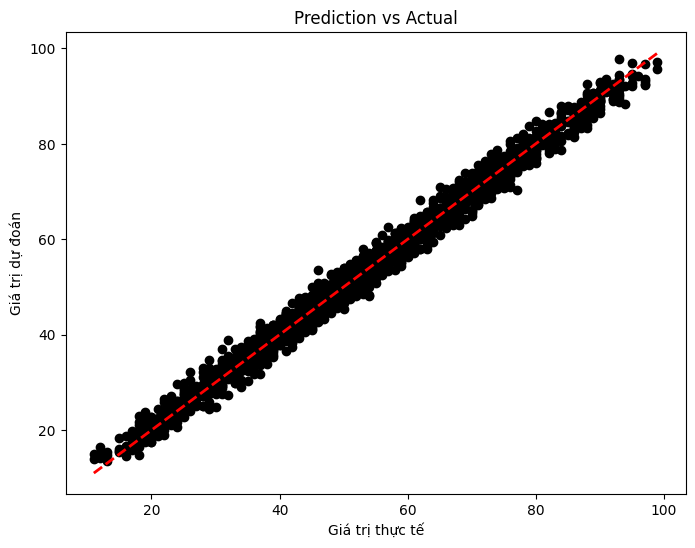

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_mlp, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Prediction vs Actual")
plt.show()

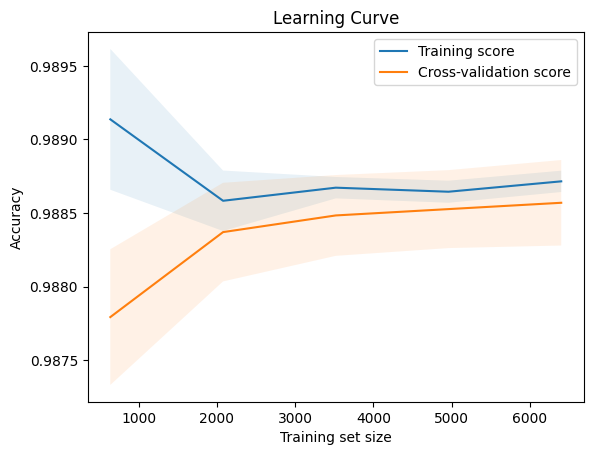

In [43]:
train_sizes, train_scores, test_scores = learning_curve(model_MLP, X_train_scaled, y_train, cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

STACKING

In [44]:
start_time = time.time()
model_stacking = StackingRegressor(
    estimators=[('mlp', model_MLP), ('lasso', model_lasso), ('linear', model_Linear)],
    final_estimator=LinearRegression()
)
model_stacking.fit(X_train_scaled, y_train)


StackingRegressor(estimators=[('mlp',
                               MLPRegressor(alpha=0.001,
                                            hidden_layer_sizes=(50,),
                                            learning_rate='adaptive',
                                            max_iter=2000, solver='sgd')),
                              ('lasso', Lasso(alpha=0.001)),
                              ('linear', LinearRegression())],
                  final_estimator=LinearRegression())

In [45]:
joblib.dump(model_stacking, 'model_stack.pkl')

['model_stack.pkl']

In [46]:
y_pred_stack = model_stacking.predict(X_test_scaled)
time_stacking = time.time() - start_time
mae_stack = mean_absolute_error(y_test, y_pred_stack)
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

In [47]:
data = {
    'Hàm đánh giá': ['MAE', 'MSE', 'R²'],
    'Giá trị': [mae_stack, mse_stack, r2_stack]
}
model_evaluation_table_stacking = pd.DataFrame(data)

print("\n\nModel Evaluation Table:")
print(model_evaluation_table_stacking.to_string(index=False))
print("\n\n")



Model Evaluation Table:
Hàm đánh giá  Giá trị
         MAE 1.611629
         MSE 4.087489
          R² 0.988970





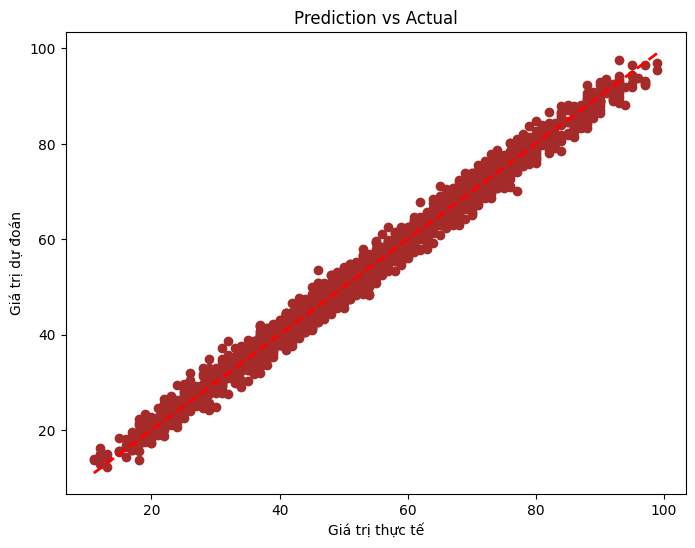

In [48]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_stack, color='brown')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Giá trị thực tế")
plt.ylabel("Giá trị dự đoán")
plt.title("Prediction vs Actual")
plt.show()

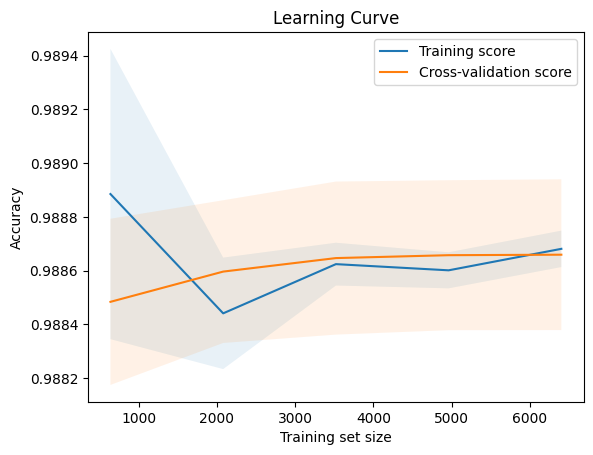

In [49]:
train_sizes, train_scores, test_scores = learning_curve(model_stacking, X_train_scaled, y_train, cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()


In [50]:
print(f"Linear Regression Training Time: {time_linear:.4f} seconds")
print(f"Lasso Regression Training Time: {time_lasso:.4f} seconds")
print(f"MLP Regressor Training Time: {time_mlp:.4f} seconds")
print(f"Stacking Regressor Training Time: {time_stacking:.4f} seconds")


Linear Regression Training Time: 0.0415 seconds
Lasso Regression Training Time: 0.4946 seconds
MLP Regressor Training Time: 0.0298 seconds
Stacking Regressor Training Time: 6.7123 seconds


In [51]:
print("\nMean Squared Error (MSE):")
print(f"Linear Regression MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Lasso Regression MSE: {mean_squared_error(y_test, y_pred_lasso):.4f}")
print(f"MLP Regressor MSE: {mean_squared_error(y_test, y_pred_mlp):.4f}")
print(f"Stacking Regressor MSE: {mean_squared_error(y_test, y_pred_stack):.4f}")



Mean Squared Error (MSE):
Linear Regression MSE: 4.0826
Lasso Regression MSE: 4.0830
MLP Regressor MSE: 4.1075
Stacking Regressor MSE: 4.0875


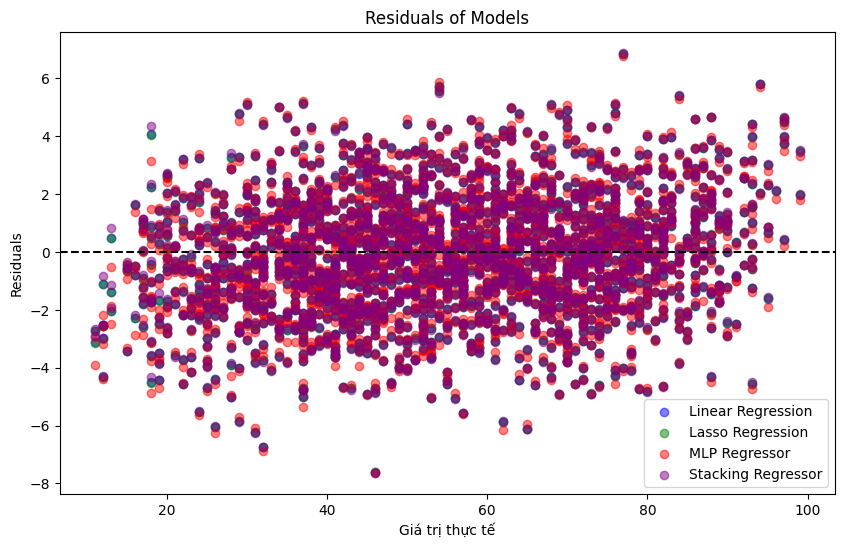

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test - y_pred, color='blue', label='Linear Regression', alpha=0.5)
plt.scatter(y_test, y_test - y_pred_lasso, color='green', label='Lasso Regression', alpha=0.5)
plt.scatter(y_test, y_test - y_pred_mlp, color='red', label='MLP Regressor', alpha=0.5)
plt.scatter(y_test, y_test - y_pred_stack, color='purple', label='Stacking Regressor', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Giá trị thực tế')
plt.ylabel('Residuals')
plt.title('Residuals of Models')
plt.legend()
plt.show()